# Integration

Brightway is designed to be used with other models, though sometimes interaction is more difficult than it should be. In this notebook, we will build a basic model of vehicle energy demand, integrate it into Brightway, and then do some global sensitivity testing.

# A simple vehicle energy model

This model is based on the work of Brian Cox. We used first principles from physics to estimate the electrical demand of an electric car.

## Input parameters:

* mass (kg): Mass of car and passengers
* efficiency (kWh/kWh): Conversion efficiency of motor electricity inputs into kinetic energy
* surface_area (m2): Frontal surface area of car
* aux_power (kW): Average power draw of auxillary systems, e.g. heating, control
* motor_power (kW): Max power of car motor
* max_recup (kWh/kWh): Max fraction of braking energy that can be recuperated
* min_recup_speed (km/h): Minimum speed at which braking recuperating system can operate
* Cr: Rolling resistance coefficient
* Cd: Aerodynamic resistance coefficient
* geno_eff (kWh/kWh): Efficiency of recuperating generator

Here are the static values for these coefficients:

* mass (kg): 1300
* efficiency (kWh/kWh): 0.85
* surface_area (m2): 2.41
* aux_power (kW): 0.721
* motor_power (kW): 80
* max_recup (kWh/kWh): 0.5
* min_recup_speed (km/h): 10
* Cr: 0.01
* Cd: 0.3
* geno_eff (kWh/kWh): 0.875

Our model also has some random noise added, so there are no perfect linear relationships between any parameters and any input parameters. We can see this by varying the motor efficency:

In [11]:
%matplotlib inline

In [12]:
import numpy as np
from car_model import energy_consumption
import matplotlib.pyplot as plt

In [13]:
efficiencies = np.linspace(0.8, 0.9, 1000)
results = np.array([energy_consumption(
    1300, efficiency, 2.41, 0.721, 80, 0.5, 10, 0.01, 0.3, 0.875
    ) for efficiency in efficiencies
])

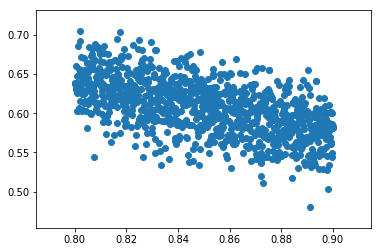

In [14]:
plt.scatter(efficiencies, results)

We can see a different pattern for minimum speed for recuperative braking:

In [15]:
variables = np.linspace(0, 50, 1000)
results = np.array([energy_consumption(
    1300, 0.85, 2.41, 0.721, 80, 0.9, v, 0.01, 0.3, 0.875
    ) for v in variables
])

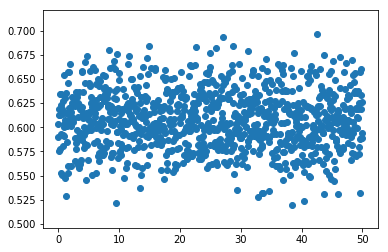

In [16]:
plt.scatter(variables, results)

And a final pattern for surface area:

In [17]:
variables = np.linspace(1.5, 5, 1000)
results = np.array([energy_consumption(
    1300, 0.85, v, 0.721, 80, 0.5, 10, 0.01, 0.3, 0.875
    ) for v in variables
])

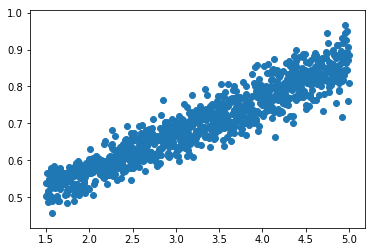

In [18]:
plt.scatter(variables, results)

# Integration into Brightway

There are a number of ways that a model can be integrated into, or linked with, Brightway. [More info and general concepts can be found in this blog post](https://chris.mutel.org/inventory-models.html). 

Taking Brightway outputs as input files for other programs is relatively simple, and you should already be able to imagine the main ways to do this. 

Incorporating the outputs of other models into Brightway is not so simple, and you already undestand enough of the structure of Brightway to see that this can happen on several levels. Can you think of three ways that model outputs could be incorprated into a Brightway calculation?

* You could import the output files and create new databases
* You could import the output files, and write processed arrays directly
* You could use the output files to modify processed arrays before they were used to build matrices
* You could build matrices directly from the output files

In [1]:
import brightway2 as bw

In this notebook, we will run our model indepent of Brightway, and modify the parameter array used to construct the technosphere matrix. Therefore, you will need to understand the `mapping` dictionary and parameter arrays!

In [2]:
bw.projects.set_current("bw2_seminar_2017")

We start by importing a simple database that allows us to more easily modify the electricity consumption of a car.

In [10]:
cars = bw.ExcelImporter("data/cars.xlsx")
cars.apply_strategies()
cars.match_database("ecoinvent 2.2", fields=['name', 'unit', 'location'])
assert not cars.statistics()[-1]
cars.write_database()

Extracted 1 worksheets in 0.01 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applied 14 strategies in 0.31 seconds
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:
0%  100%
[##] | ETA: 00:00:00
Total time elapsed: 00:00:00


2 datasets
6 exchanges
0 unlinked exchanges
  
Title: Writing activities to SQLite3 database:
  Started: 03/26/2017 18:18:31
  Finished: 03/26/2017 18:18:31
  Total time elapsed: 00:00:00
  CPU %: 113.30
  Memory %: 0.79
Created database: Electric cars


The current value for electricity input to our functional unit is a dummy value of 0.5:

In [20]:
driving = bw.get_activity(('Electric cars', 'driving'))

for ex in driving.technosphere():
    print(ex)

Exchange: 0.5 kilowatt hour 'Electricity' (kilowatt hour, RER, None) to 'Driving' (kilometer, RER, None)>
Exchange: -0.625 kilometer 'operation, passenger car, electric, LiMn2O4, city car' (kilometer, CH, ['transport systems', 'road']) to 'Driving' (kilometer, RER, None)>
Exchange: 1.0 person kilometer 'transport, passenger car, electric, LiMn2O4, city car' (person kilometer, CH, ['transport systems', 'road']) to 'Driving' (kilometer, RER, None)>


If we run our model with the default inputs, we get a different value:

In [21]:
energy_consumption(1300, 0.85, 2.41, 0.721, 80, 0.5, 10, 0.01, 0.3, 0.875)

0.58594938142559128

To use this modelled value during the LCA calculation, we could try to disassemble the process of turning processed arrays into the correct matrices. However, it will be much easier to take a shortcut. Let's look at the method `LCA.rebuild_technosphere_matrix`:

    def rebuild_technosphere_matrix(self, vector):
        """Build a new technosphere matrix using the same row and column indices, but different values. Useful for Monte Carlo iteration or sensitivity analysis.

        Args:
            * *vector* (array): 1-dimensional NumPy array with length (# of technosphere parameters), in same order as ``self.tech_params``.

        Doesn't return anything, but overwrites ``self.technosphere_matrix``.

        """
        self.technosphere_matrix = MatrixBuilder.build_matrix(
            self.tech_params, self._activity_dict, self._product_dict,
            "row", "col",
            new_data=TBMBuilder.fix_supply_use(self.tech_params, vector.copy())
        )

So, instead of doing something complicated, all we have to do is to find the relevant row in the `tech_params` array, change it, and then call `lci_calculation()` and `lcia()`.

In [24]:
lca = bw.LCA({('Electric cars', 'driving'): 1}, method=('ReCiPe Endpoint (E,A)', 'human health', 'particulate matter formation'))
lca.lci()

The activity and biosphere dictionaries already reference row and column values:

In [25]:
lca.activity_dict

{('ecoinvent', 'b6a162acba0b222fa3c3e9c67bb2debf'): 0,
 ('ecoinvent', 'a661f2fdd387d32f45b063695f27caf6'): 1,
 ('ecoinvent', '44ca6315131e5c03a04a7fe9dda74e11'): 2,
 ('ecoinvent', 'fe0a5e78c32830bb819fea4323a944fe'): 3,
 ('ecoinvent', '8e9dabf2e1c701ae554416f7e9104adc'): 4,
 ('ecoinvent', '9491f597d2810674eef438594e967197'): 5,
 ('ecoinvent', '5dd549d5b66fb7e0880111d1556cd574'): 6,
 ('ecoinvent', 'fe459ba639cdcdd80c4d385b97fde640'): 7,
 ('ecoinvent', 'ba022657b1f26fd727ac1d27c2ee273e'): 8,
 ('ecoinvent', 'c1aa4fde7d68224e4331c820116664bd'): 9,
 ('ecoinvent', '5aea17457cded80aeb8c04d967b5d00f'): 10,
 ('ecoinvent', 'affb5f4897e5e2ef2741de5f7b552bdd'): 11,
 ('ecoinvent', '06215c3389d6c4336bec8e8babbca3b9'): 12,
 ('ecoinvent', '1654194b472a4de801e92f6f1086a938'): 13,
 ('ecoinvent', '35efaa54e7062d45909708a5c7eba00d'): 14,
 ('ecoinvent', '60e91db7e25cd9e1513bc299a7bb0f99'): 15,
 ('ecoinvent', '3bedf2cc138a20b31553f0b80bbb88e8'): 16,
 ('ecoinvent', 'a40198d2ef441486f27c8665caee8d4d'): 17,
 (

So we can iterate through the `tech_params` array and select the correct element:

In [28]:
row = lca.product_dict[('Electric cars', 'electricity')]
col = lca.activity_dict[('Electric cars', 'driving')]

our_row = []

for i, obj in enumerate(lca.tech_params):
    if obj['row'] == row and obj['col'] == col:
        our_row.append(i)
        
assert len(our_row) == 1
our_row = our_row[0]
our_row

4092

Now we can substitute in our model value in the column `amount`:

In [33]:
lca.tech_params[our_row]['amount'] = energy_consumption(1300, 0.85, 2.41, 0.721, 80, 0.5, 10, 0.01, 0.3, 0.875)
lca.rebuild_technosphere_matrix(lca.tech_params['amount'])

In [34]:
lca.lci_calculation()
lca.lcia()
lca.score

0.001061660535659884

To prove that we actually did somthing, let's redo the LCA without this change:

In [32]:
lca = bw.LCA({('Electric cars', 'driving'): 1}, method=('ReCiPe Endpoint (E,A)', 'human health', 'particulate matter formation'))
lca.lci()
lca.lcia()
lca.score

0.0009630632271695478